In [1]:
import scipy, GPy, popmachine
from GPy.kern import RBF
from derivative import RBFDerivative
import pandas as pd

In [2]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
m = popmachine.machine.Machine()

for p in m.list(popmachine.models.Plate):
    print p

ecoli-eo499-propionicAcid-1 (252)
hsal-gradientTest-1 (200)


In [5]:
ds = m.search(plates=['ecoli-eo499-propionicAcid-1'],include=['pH', 'propionicAcidmM', 'rep'], )
ds.data.shape

(33, 252)

In [6]:
ds.trim(3)
ds.data.shape

(30, 252)

In [7]:
ds.log()

In [8]:
melt = ds.melt()
melt.head()

,plate,number,pH,propionicAcidmM,rep,time,od
0,ecoli-eo499-propionicAcid-1,1,7.0,0.0,0,1.5,-1.988504
1,ecoli-eo499-propionicAcid-1,2,7.0,0.0,1,1.5,-1.948976
2,ecoli-eo499-propionicAcid-1,3,7.0,0.0,2,1.5,-2.358454
3,ecoli-eo499-propionicAcid-1,4,7.0,2.0,0,1.5,-2.058894
4,ecoli-eo499-propionicAcid-1,5,7.0,2.0,1,1.5,-2.035047


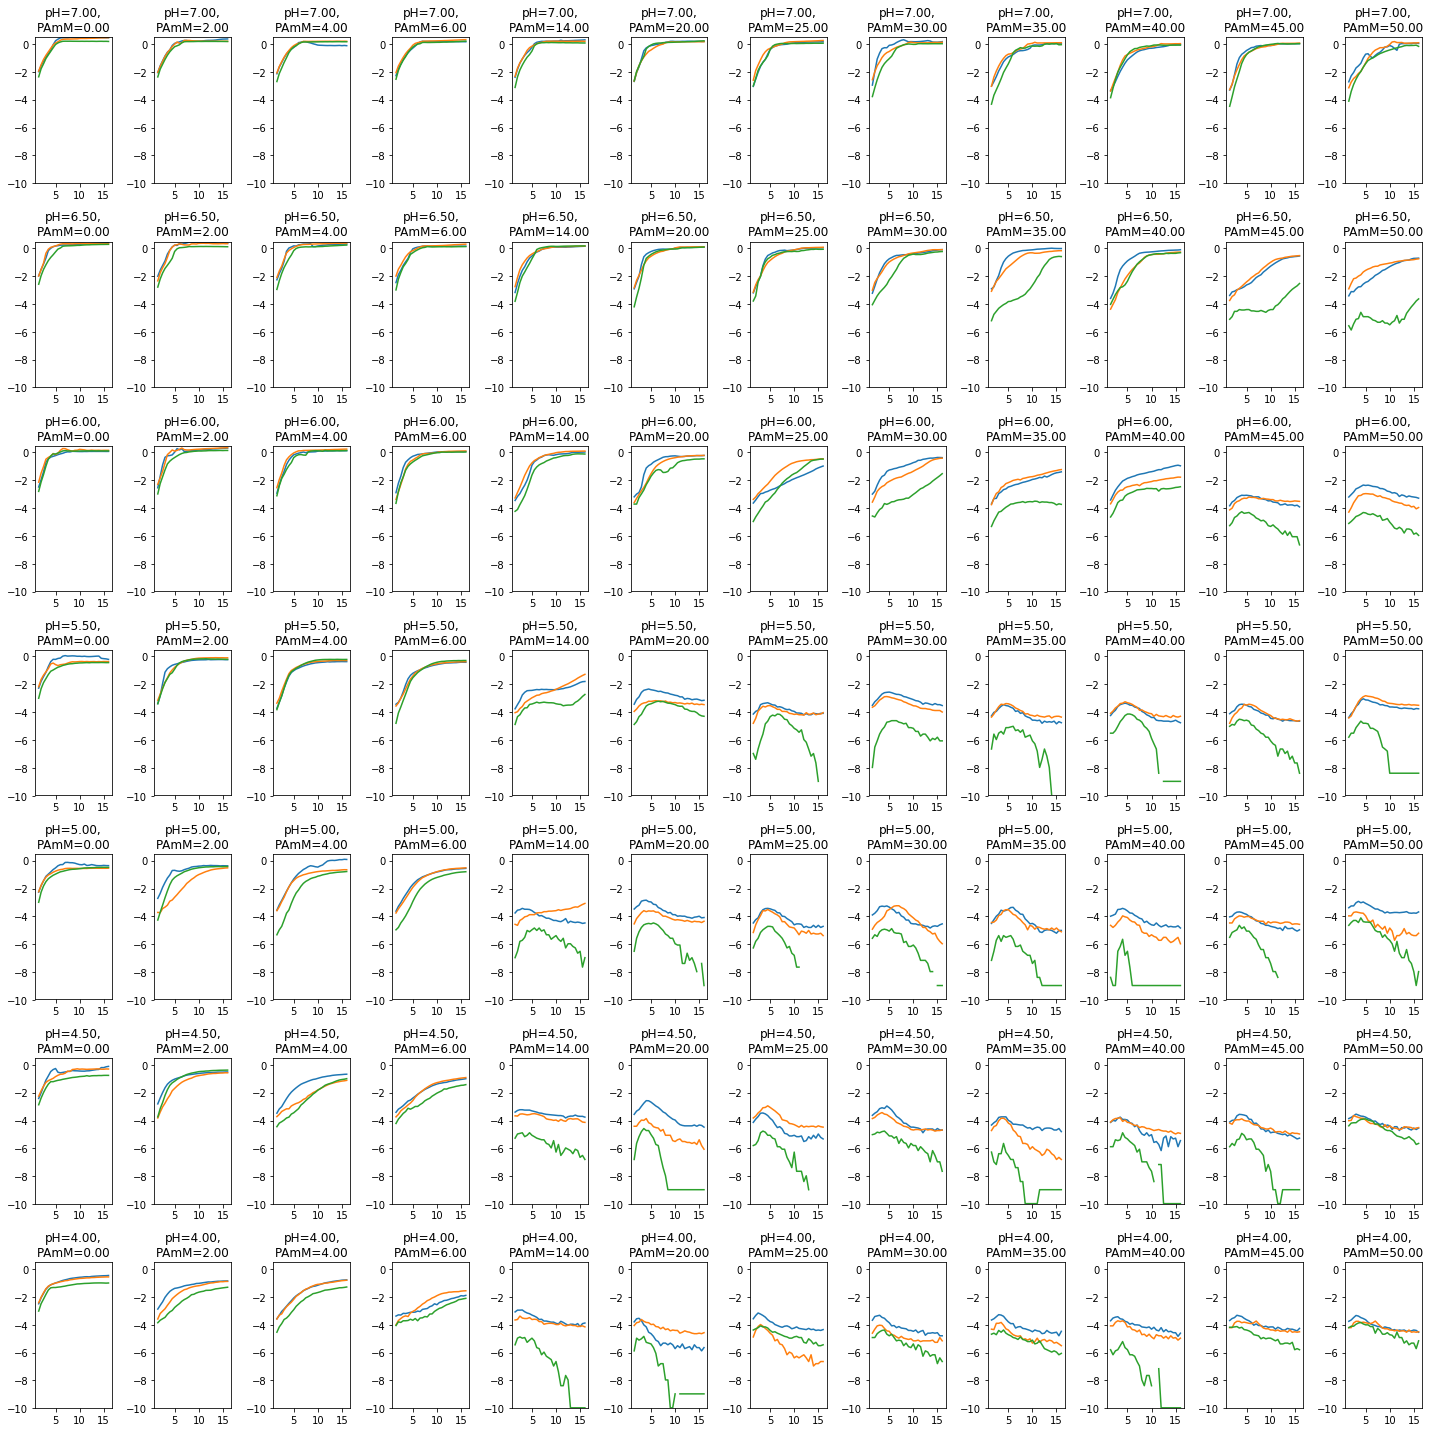

In [9]:
plt.figure(figsize=(20,20))

g = melt.groupby(['pH','propionicAcidmM'])

for i, ph in enumerate(melt.pH.unique()):
    for j, pa in enumerate(melt.propionicAcidmM.unique()):
        temp = g.get_group((ph,pa))
        
        plt.subplot(melt.pH.unique().shape[0],melt.propionicAcidmM.unique().shape[0],i*melt.propionicAcidmM.unique().shape[0]+j+1)
        plt.title("pH=%.2lf,\nPAmM=%.2lf"%(ph, pa))
        
        g2 = temp.groupby('rep')
        for j,temp2 in g2:
            plt.plot(temp2.time, temp2.od)
        
        plt.ylim(np.nanmin(melt.od.values),np.nanmax(melt.od.values))
        
plt.tight_layout()

In [93]:
# melt = pd.melt(pivot, pivot.columns[:ds.meta.shape[1]].tolist(), pivot.columns[ds.meta.shape[1]:].tolist(), var_name='time', value_name='od')

# # remove starting time point
# g = melt.groupby(['pH','propionicAcidmM'])
# s = g.apply(lambda x: x.od[x.time==melt.time.min()].mean())
# s.name = 'startod'
# melt.od /= melt.join(s, on=['pH','propionicAcidmM'], rsuffix='_r').startod

# # remove 0 observations
# melt = melt[melt.od>0]
            
# # log2
# melt.od = np.log2(melt.od)

# # renorm outliers
# g = melt.groupby(['pH','propionicAcidmM','rep'])
# s = g.apply(lambda x: x.od[x.time==melt.time.min()].mean())
# s.name = 'startod'
# s2 = g.apply(lambda x: x.od[x.time==melt.time.min()].mean()<-1)
# s2.name = 'outlier'

# select = melt.join(s2, on=['pH','propionicAcidmM','rep'], rsuffix='_r').outlier
# melt.od[select] -= melt.join(s, on=['pH','propionicAcidmM','rep'], rsuffix='_r').startod[select]

# # remove extreme outliers
# melt = melt[melt.od>-2]

# melt.head()

,pH,propionicAcidmM,rep,time,od
0,7.0,0.0,0,1.5,0.098718
1,7.0,0.0,1,1.5,0.138246
2,7.0,0.0,2,1.5,-0.271232
3,7.0,2.0,0,1.5,0.086712
4,7.0,2.0,1,1.5,0.110558


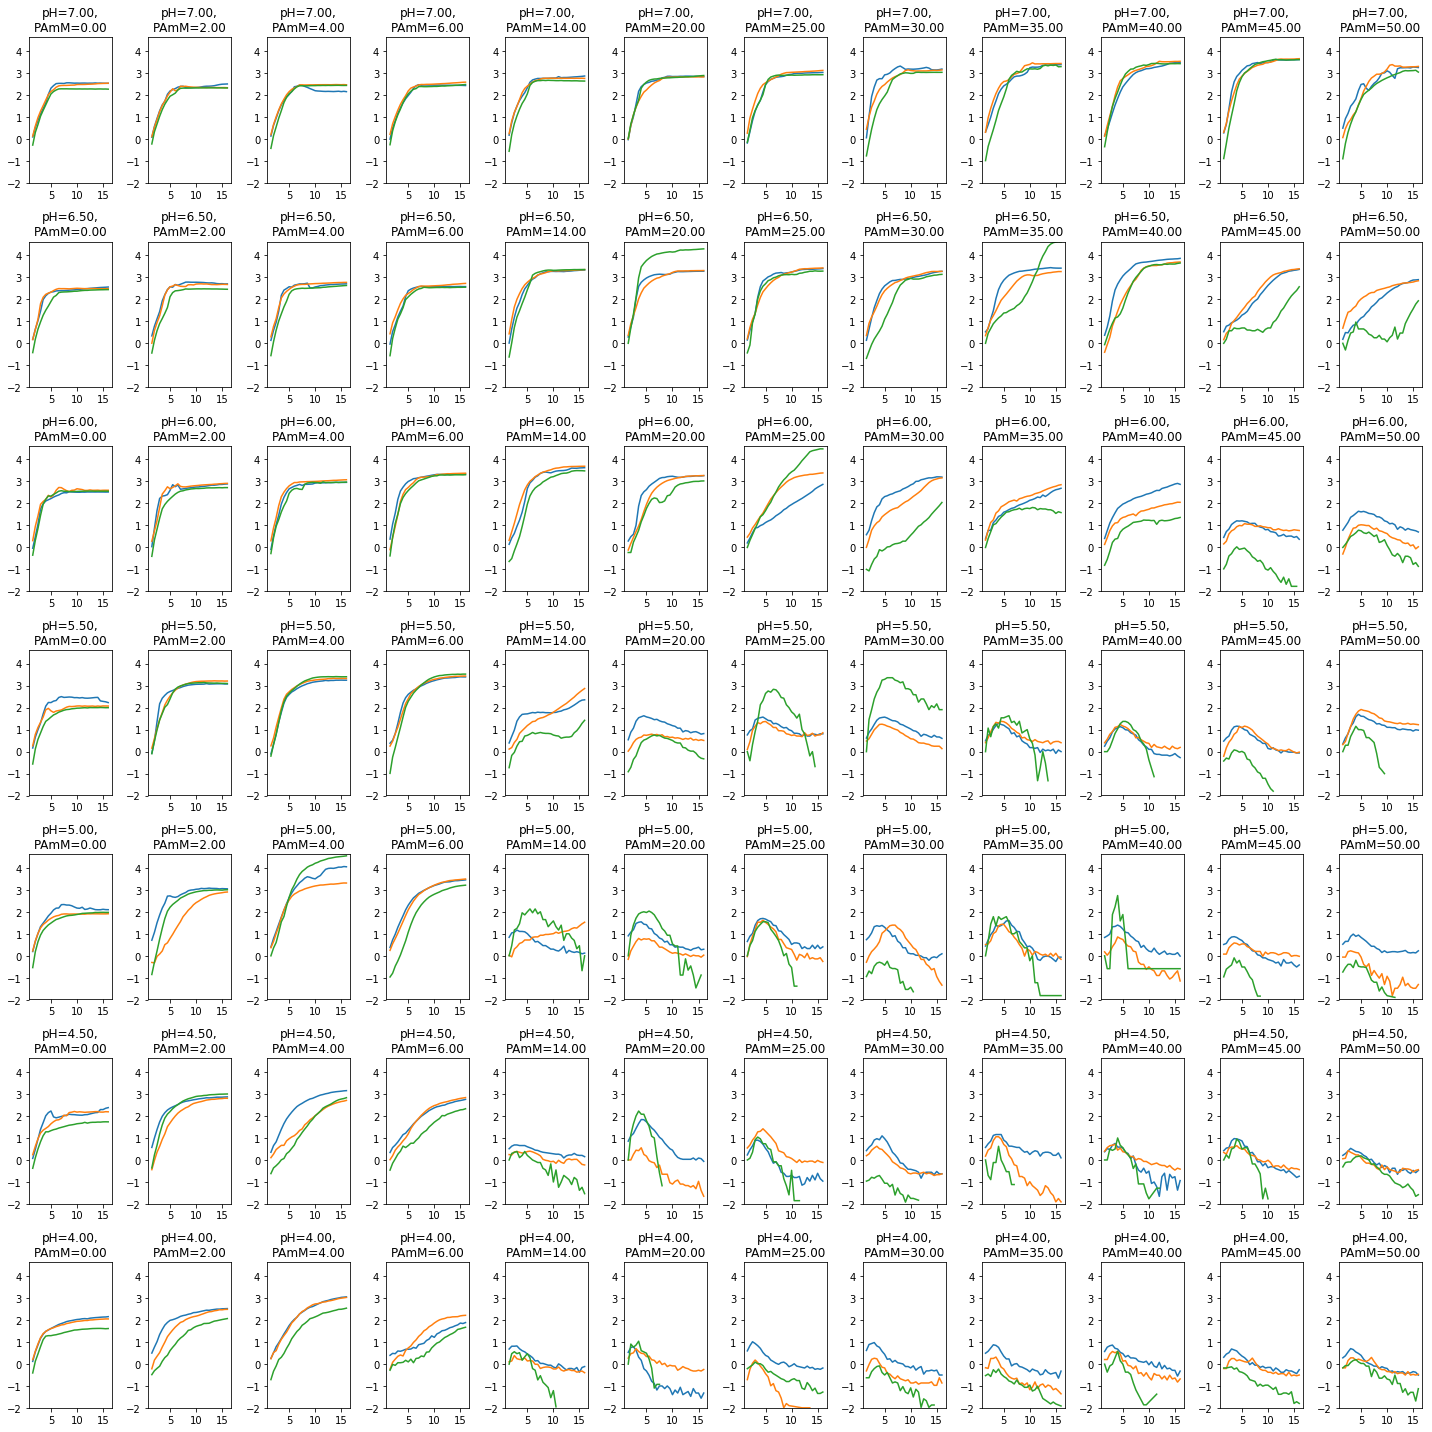

In [94]:
plt.figure(figsize=(20,20))

g = melt.groupby(['pH','propionicAcidmM'])

for i, ph in enumerate(melt.pH.unique()):
    for j, pa in enumerate(melt.propionicAcidmM.unique()):
        temp = g.get_group((ph,pa))
        
        plt.subplot(melt.pH.unique().shape[0],melt.propionicAcidmM.unique().shape[0],i*melt.propionicAcidmM.unique().shape[0]+j+1)
        plt.title("pH=%.2lf,\nPAmM=%.2lf"%(ph, pa))
        
        g2 = temp.groupby('rep')
        for j,temp2 in g2:
            plt.plot(temp2.time, temp2.od)
        
        plt.ylim(melt.od.min(),melt.od.max())
        
plt.tight_layout()

plt.savefig("figures/lund/ecoli.pdf",dpi=300,bbox_inches='tight')

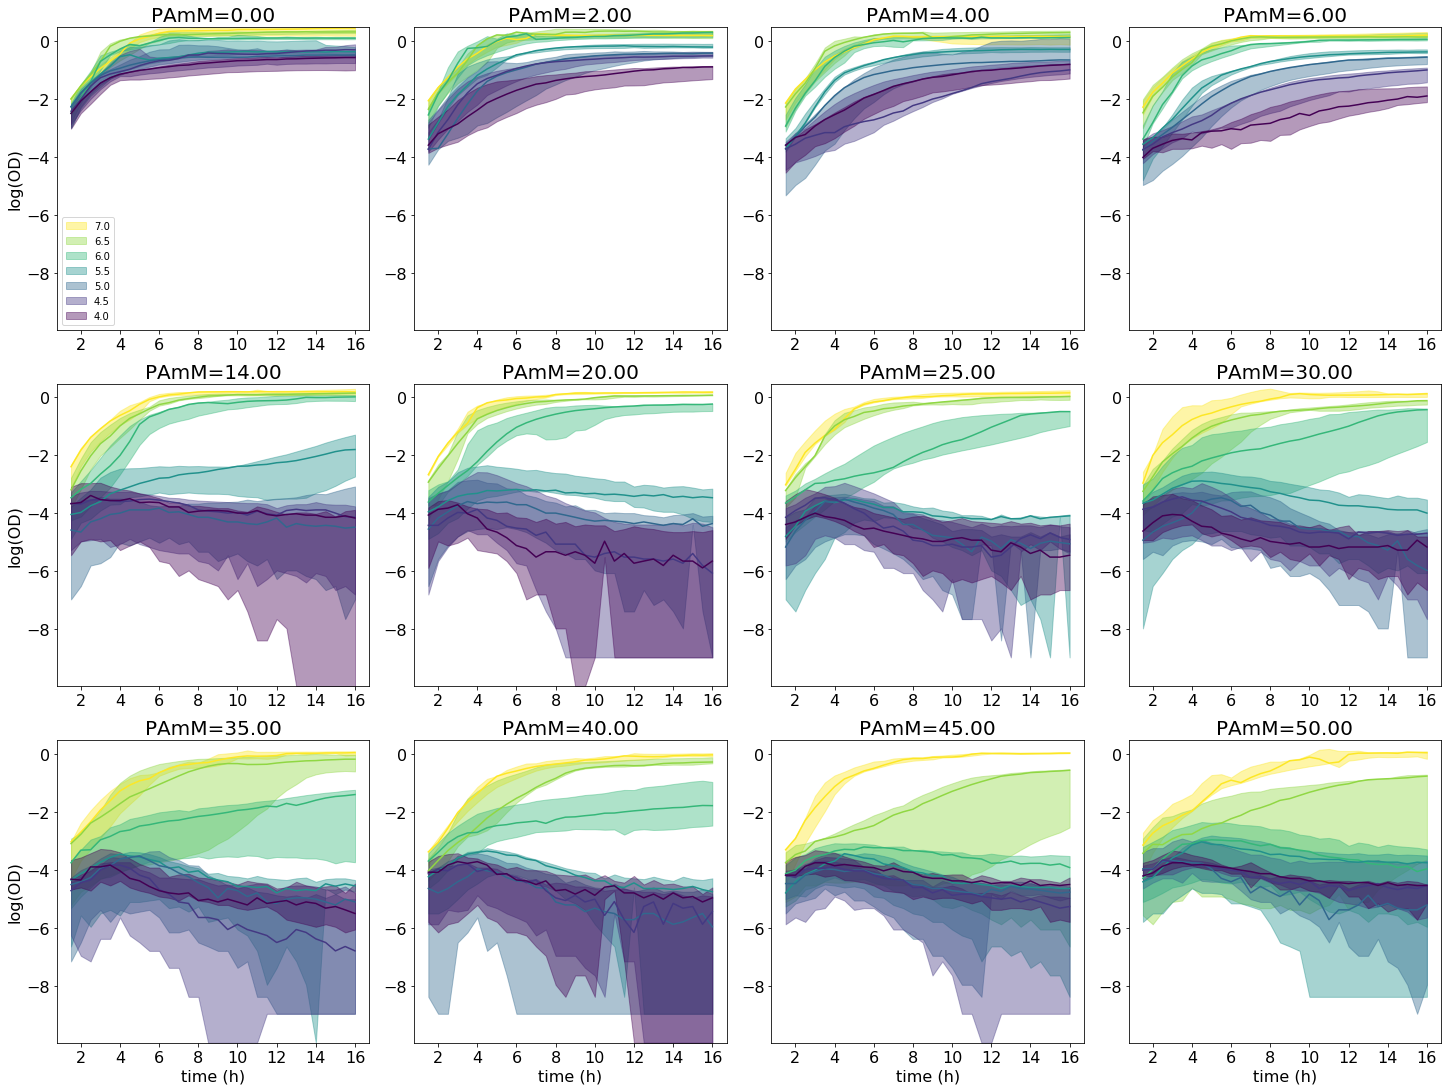

In [12]:
nrow,ncol = 3,4
plt.figure(figsize=(20,15))

g = melt.groupby(['pH','propionicAcidmM'])

for i, ph in enumerate(melt.pH.unique()):
    for j, pa in enumerate(melt.propionicAcidmM.unique()):
        temp = g.get_group((ph,pa))
        temp = temp.pivot('time', 'rep', 'od')
        
        plt.subplot(nrow,ncol,j+1)
        plt.title("PAmM=%.2lf"%(pa),fontsize=20)
        
        color = (ph-4)/3
        
        #plt.plot(temp.index, temp,c=plt.get_cmap()(color))
        plt.plot(temp.index, temp.median(1),c=plt.get_cmap()(color))
        plt.fill_between(temp.index, temp.min(1), temp.max(1),color=plt.get_cmap()(color),alpha=.4,label=ph)
        
        plt.ylim(melt.od.min(),melt.od.max())
        
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
plt.tight_layout()

plt.subplot(nrow,ncol,1)
plt.legend(loc='best')

for c in range(ncol):
    plt.subplot(nrow,ncol,(nrow-1)*ncol+c+1)
    plt.xlabel("time (h)", fontsize=16)
    
for r in range(nrow):
    plt.subplot(nrow,ncol,r*ncol+1)
    plt.ylabel("log(OD)", fontsize=16)

# plt.savefig("figures/lund/ecoli-shaded.pdf",dpi=300,bbox_inches='tight')

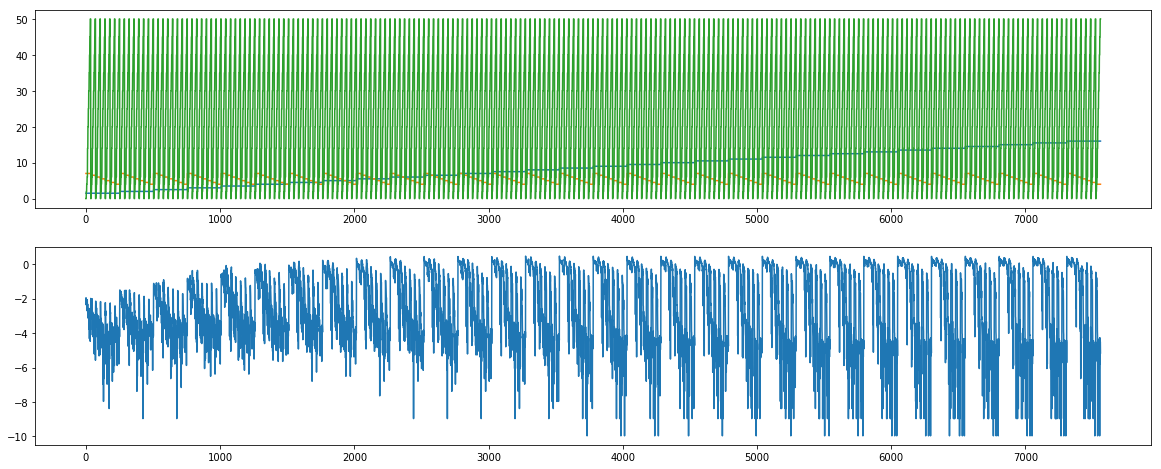

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.plot(melt[['time','pH','propionicAcidmM']])

plt.subplot(212)
plt.plot(melt.od)

In [14]:
melt.to_csv("data/normalized/lund/propionicAcid-ecoli/tidy.csv",index=False)